In [82]:
import tensorflow as tf
# from tensorflow import keras 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from datetime import datetime 

In [83]:
# suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [84]:
df = pd.read_csv("commodity_historical.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   780 non-null    object 
 1   Crude Oil Brent Price  780 non-null    float64
 2   Cocoa Price            780 non-null    float64
 3   Gold Price             780 non-null    float64
dtypes: float64(3), object(1)
memory usage: 24.5+ KB


In [85]:
data = df[["date", "Gold Price"]]
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        780 non-null    object 
 1   Gold Price  780 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.3+ KB


In [86]:
data['date'] = pd.to_datetime(data['date'])

/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_48972/736794659.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [87]:
data = data[data["date"] >= "1980-01-01"]  # instead of 1960 which is statistically insignificant

In [88]:
import plotly.express as px
import plotly.graph_objects as go


def plotting(title, data, x, y, x_label, y_label, text=False, lam=None):
    """General function to plot the data."""
    fig = px.line(data, x=data[x], y=data[y], labels={x: x_label, y: y_label})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title, width=650, title_x=0.5, height=400)
    if text:
      fig.add_annotation(
          x='1952-12-20', y=10, text=f'Lambda = {lam:.3f}',
          align='left', yanchor='bottom', showarrow=False,
          font=dict(size=20, color="black", family="Courier New, monospace"),
          bordercolor='black', borderwidth=2, bgcolor="white"
      )
    fig.show()


def add_separator(width=650):
    """Add a horizontal line as a separator."""
    fig = go.Figure()
    fig.add_hline(y=0.5, line_dash="dot", line_color="gray", line_width=2)
    fig.update_layout(height=50, width=width, margin=dict(l=20, r=20, t=20, b=20), xaxis_visible=False, yaxis_visible=False)
    fig.show()


In [89]:
plotting(title='Gold Over Time', data=data, x='date', y='Gold Price', x_label='Date', y_label='Price ()')
# add_separator()

In [90]:
len(data)

540

## Data Split

In [91]:
train = data.iloc[:528]  # 1980 to 2023
test = data.iloc[528:]  # 2024

In [92]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data["Crude Oil Brent Price"])
scaler.fit(train[["Gold Price"]])
scaled_train = scaler.transform(train[["Gold Price"]])
scaled_test = scaler.transform(test[["Gold Price"]])

In [93]:
train_size = int(len(scaled_train) * 0.95)  # 95% train, 5% validation
train_data, val_data = scaled_train[:train_size], scaled_train[train_size:]

In [94]:
LOOKBACK = 1

In [95]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Define Parameters
lookback = LOOKBACK  # Number of past steps to use as input
batch_size = 32  # Number of samples per batch
n_features = 1

# Initialize Generator
# train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=lookback, batch_size=batch_size)
train_generator = TimeseriesGenerator(train_data, train_data, length=lookback, batch_size=batch_size)
val_generator = TimeseriesGenerator(val_data, val_data, length=lookback, batch_size=batch_size)

## Build base lstm

In [96]:
# Set random seed for reproducibility
tf.random.set_seed(3)

# Build LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True), 
        input_shape=(lookback, n_features)
    ),  # 1st layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False)),  # 2nd layer
    tf.keras.layers.Dense(256, activation="relu"),  # 3rd Layer (Dense)
    tf.keras.layers.Dropout(0.2),  # 4th Layer (Dropout)
    tf.keras.layers.Dense(1)  # Final Output Layer
])

# Configure ADAM optimizer with specified parameters
# optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,  # Specified learning rate
#     beta_1=0.9,  # First moment estimate decay rate
#     beta_2=0.999  # Second moment estimate decay rate
# )
# optimizer = tf.keras.optimizers.RMSprop(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.0,
#     epsilon=1e-7
# )
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=0.001,
    weight_decay=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer, 
    loss="MeanAbsolutePercentageError", 
    metrics=["mse"]
)


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [97]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 1, 256)         │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 593,409 (2.26 MB)

 Trainable params: 593,409 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# fit model
model.fit(train_generator, epochs=50)

Epoch 1/50


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 109322.7422 - mse: 0.1075
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 160614.0000 - mse: 0.1289    
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39044.1836 - mse: 0.1227
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 398.0465 - mse: 0.1623
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7835.1143 - mse: 0.2189
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17740.6289 - mse: 0.0668
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47868.1133 - mse: 0.1231     
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 604.3326 - mse: 0.1365
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8140.7246 - mse: 0.1115
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3039.1929 - mse: 0.2204
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15666.3936 - mse: 0.1332
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 406.4558 - mse: 0.2201
Epoch 13/5

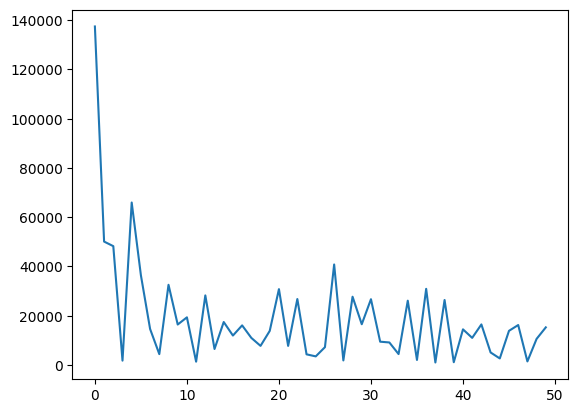

In [99]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [100]:
def plot_forecasts(df: pd.DataFrame, forecasts: np.ndarray, col: str, title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    
    # Plot true values
    fig.add_trace(go.Scatter(x=df['date'], y=df[col], name='Truth', mode='lines'))
    
    # Plot predicted values
    fig.add_trace(go.Scatter(x=df['date'], y=forecasts.flatten(), name='Prediction', mode='lines'))
    
    fig.update_layout(
        template="simple_white", font=dict(size=18), title_text=title,
        width=650, title_x=0.5, height=400, xaxis_title='Date', yaxis_title='Price'
    )
    
    fig.show()

## Train set

In [101]:
train_predictions = []

first_eval_batch = scaled_train[:lookback]
current_batch = first_eval_batch.reshape((1, lookback, n_features))

for i in range(len(train)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    train_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━

In [102]:
# Ensure test predictions is a 2D NumPy array before inverse scaling
true_predictions = scaler.inverse_transform(np.array(train_predictions).reshape(-1, 1))

# Extract correct test set dates
train_dates = data['date'].iloc[:len(train)]

In [103]:
plot_forecasts(
    pd.DataFrame({
        'date': train_dates, 
        "Gold Price": train["Gold Price"].values
    }), 
    true_predictions, 
    "Gold Price", 
    "LSTM forecast for Gold train set"
)

## Test set

In [104]:
test_predictions = []

first_eval_batch = scaled_train[-lookback:]
current_batch = first_eval_batch.reshape((1, lookback, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [105]:
# Ensure test predictions is a 2D NumPy array before inverse scaling
true_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))

# Extract correct test set dates
test_dates = data['date'].iloc[len(train):]

In [106]:
plot_forecasts(
    pd.DataFrame({
        'date': test_dates, 
        "Gold Price": test["Gold Price"].values
    }), 
    true_predictions, 
    "Gold Price", 
    "LSTM forecast for Gold test set"
)

In [107]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Gold Price'], true_predictions))
rmse

2139.593724409476

In [ ]:
model.save("saved_models/gold_lstm_model.keras")

## Grid Search Hyperparameter Tuning

In [ ]:
import keras_tuner as kt

# Set random seed for reproducibility
tf.random.set_seed(3)

# Assume `train_data` and `val_data` are numpy arrays (shape: [samples, features])
n_features = train_data.shape[1]

# Tune batch sizes
batch_sizes = [8, 16, 32, 64]

# Create dictionary to store generators for different batch sizes
generators = {}

for batch_size in batch_sizes:
    generators[batch_size] = {
        'train': TimeseriesGenerator(train_data, train_data.reshape(-1, 1), length=lookback, batch_size=batch_size),
        'val': TimeseriesGenerator(val_data, val_data.reshape(-1, 1), length=lookback, batch_size=batch_size)
    }

def build_model(hp):
    """
    Model builder function for Keras Tuner
    """

    # Tune the lookback period
    # lookback = hp.Int('lookback', min_value=1, max_value=24, step=1)

    # Define model using Input layer first
    inputs = tf.keras.layers.Input(shape=(lookback, n_features))

    # Tune the number of units in the first LSTM layer
    units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=units_1, return_sequences=True))(inputs)

    # Tune the number of units in the second LSTM layer
    units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=units_2, return_sequences=False))(x)

    # Tune the number of units in the dense layer
    units_dense = hp.Int('units_dense', min_value=64, max_value=256, step=64)
    x = tf.keras.layers.Dense(units=units_dense, activation='relu')(x)

    # Tune the dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(1)(x)

    # Define the final model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2, 1e-1, 3e-2, 3e-1])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='MeanAbsolutePercentageError',
        metrics=['mse']
    )

    return model

# Initialize the tuner
tuner = kt.GridSearch(
    build_model,
    objective='val_loss',
    # max_trials=100,  # Number of different hyperparameter combinations to try
    directory='tuning_dir',
    project_name='gold_lstm_tuning'
)

# Print search space summary
tuner.search_space_summary()

# Tune epochs
epoch_choices = [50, 100, 150]

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Start the hyperparameter search
for batch_size in batch_sizes:
    tuner.search(
        generators[batch_size]['train'],
        epochs=max(epoch_choices),
        validation_data=generators[batch_size]['val'],
        callbacks=[early_stopping]
    )

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters found:
- First LSTM layer units: {best_hps.get('units_1')}
- Second LSTM layer units: {best_hps.get('units_2')}
- Dense layer units: {best_hps.get('units_dense')}
- Dropout rate: {best_hps.get('dropout_rate')}
- Learning rate: {best_hps.get('learning_rate')}
""")

# Tune Batch Size & Epochs
best_batch_size = None
best_epoch = None
best_val_loss = float('inf')

for batch_size in batch_sizes:
    for epochs in epoch_choices:
        print(f"Testing batch size {batch_size} with {epochs} epochs...")

        # Build the best model found
        model = tuner.hypermodel.build(best_hps)

        # Train with current batch size & epochs
        history = model.fit(
            generators[batch_size]['train'],
            epochs=epochs,
            validation_data=generators[batch_size]['val'],
            callbacks=[early_stopping],
            verbose=0  # Suppress output for cleaner logs
        )

        # Get the final validation loss
        final_val_loss = min(history.history['val_loss'])

        # Update best batch size & epoch count if a lower val_loss is found
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_batch_size = batch_size
            best_epoch = epochs

print(f"""
Best batch size and epoch found:
- Batch size: {best_batch_size}
- Epochs: {best_epoch}
- Final validation loss: {best_val_loss}
""")

# Train the Best Model with Best Batch Size & Epochs
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    generators[best_batch_size]['train'],
    epochs=best_epoch,
    validation_data=generators[best_batch_size]['val'],
    callbacks=[early_stopping]
)

# Save the best model
best_model.save('saved_models/best_gold_lstm_model.keras')


In [ ]:
best_model.summary()

In [ ]:
loss_per_epoch = best_model.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
# Create a sequence that includes the end of training data + test data
# This allows us to make predictions for the full test set
input_sequence = np.vstack([scaled_train[-LOOKBACK:], scaled_test])

# Initialize predictions array
test_predictions = []

# For each point in the test set
for i in range(len(scaled_test)):
    # Extract the current window (LOOKBACK previous points)
    current_window = input_sequence[i:i+LOOKBACK].reshape(1, LOOKBACK, n_features)
    
    # Generate prediction for the next point
    pred = best_model.predict(current_window)[0]
    test_predictions.append(pred)

# Convert to numpy array and inverse transform
test_predictions = np.array(test_predictions).reshape(-1, 1)
true_predictions = scaler.inverse_transform(test_predictions)

# Now test_predictions and test["Gold Price"] should have the same length
rmse = sqrt(mean_squared_error(test["Gold Price"], true_predictions))
print(f"RMSE: {rmse}")

In [ ]:
print(f"""
    best batch size: {best_batch_size}, 
    best epoch: {best_epoch}
""")